# EDA: abalone

This notebook demonstrates an example EDA for a simple dataset that is intended to show a typical EDA process.

Purpose: 
1. To explore what the data look like and preliminarily check things like numebr of samples, feature types, missing values, etc. Anything that could make the data ideal or harder to work with. 
2. It also provides a playground in case we are working with a model later and want to remind ourselves what some particular feature or something looks like.
3. Also cleaning, denoising and saving the data in a format that is consistent so different models can be compared using the same data is useful.

In [2]:
%reload_ext autoreload
%autoreload 2

In [4]:
from ucimlrepo import fetch_ucirepo
from sklearn.decomposition import FastICA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from helpers.base_imports import *

*Note: Custom helper classes like `EDA` and `Experiment` are used since EDAs and Experiments with different models and hyperparameters are used over and over again. That way comparison across datasets and across experiments/models is easier.*

## Create new EDA

In [5]:
# to create a new EDA just give it a name, if one already exists with that name it will load the existing one
# eda = EDA(name="abalone1", create_new=True)  # create new
# eda = EDA(name="abalone1")  # create new

eda = EDA(name="abalone")  # load existing
eda

Loading 'edas.csv'
Loading 'abalone' eda


EDA: abalone
Columns: Index(['description', 'n features', 'n samples', 'f/n ratio', 'noise', 'stats',
       'class balance', 'outliers', 'skewness', 'correlations',
       'DR potential'],
      dtype='object')
Datasets: Index(['abalone'], dtype='object', name='dataset')

## Get raw dataset from remote source

In [4]:
# fetch dataset
data = fetch_ucirepo(id=1)

X will contain the features and y will contain the target (rings). We will also use df to contain the whole dataset (features + target).

In [5]:
X = data.data.features
y = data.data.targets

df = pd.concat([X, y], axis=1)
disp_df(df)

,Sex,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550,7
5,I,0.425,0.300,0.095,0.3515,0.1410,0.0775,0.1200,8
6,F,0.530,0.415,0.150,0.7775,0.2370,0.1415,0.3300,20
7,F,0.545,0.425,0.125,0.7680,0.2940,0.1495,0.2600,16
8,M,0.475,0.370,0.125,0.5095,0.2165,0.1125,0.1650,9
9,F,0.550,0.440,0.150,0.8945,0.3145,0.1510,0.3200,19


In [6]:
print(f"X is a df with features and values: {X.columns} of shape {X.shape}")
print(f"y is a df with target values: {y.columns} of shape {y.shape}")

X is a df with features and values: Index(['Sex', 'Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight',
       'Viscera_weight', 'Shell_weight'],
      dtype='object') of shape (4177, 8)
y is a df with target values: Index(['Rings'], dtype='object') of shape (4177, 1)


We can see that sex is I, F, or M (infant, female, or male). 

Let's 1-hot encode the sex column to make it easier to work with down the road.

In [7]:
# count the number of I, F, and M in the sex column
sex_counts = df["Sex"].value_counts()

Note: instances of each I, F and M are not equal

In [8]:
# one-hot encode the sex column
df = pd.get_dummies(df, columns=["Sex"], dtype=int)
df.head()

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Rings,Sex_F,Sex_I,Sex_M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15,0,0,1
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7,0,0,1
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9,1,0,0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10,0,0,1
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7,0,1,0


And do the same with X

In [9]:
X = pd.get_dummies(X, columns=["Sex"], dtype=int, drop_first=True)
# Note drops the first column to avoid redudant information
X.head()

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight,Sex_I,Sex_M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,0,1
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,0,1
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,0,0
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,0,1
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,1,0


In [10]:
y.columns

Index(['Rings'], dtype='object')

In [11]:
X.shape, y.shape

((4177, 9), (4177, 1))

In [12]:
len(X.columns)

9

So what does our dataset shape look like?

In [13]:
eda.update_param(
    "description", "Predict the age (ie rings) of abalone from physical measurements"
)
eda.update_param("n features", X.shape[1])
eda.update_param("n samples", X.shape[0])
eda.update_param("f/n ratio", X.shape[1] / X.shape[0])

In [14]:
eda.summary_df

,description,n features,n samples,f/n ratio,noise,stats,class balance,outliers,skewness,correlations,DR potential
dataset,,,,,,,,,,,
abalone,Predict the age (ie rings) of abalone from phy...,9,4177,0.002155,"None, no missing vals",strangeness,Normal with slight right skew,many outliers,lots of skweness in the data,several strong (>.8) correlations,"PCA: 4 components to explain 95% variance, ICA..."


So, in this dataset we are working with ~4k examples/samples/instances and 9 features. 

Our f/n is .002 which is LOW (ie. if  F/N = 0.002 , then for every 1 feature, there are approximately 500 samples ( 1/0.002 ).

F/N interpretation:

Low F/N (e.g., <0.01):
- Typically, sufficient data is available for training.
- Emphasis can be placed on optimizing model complexity or exploring more advanced models.


Moderate F/N (e.g., ~0.1–1):
- The dataset has a balanced number of features and samples.
- Careful attention is needed to avoid overfitting with complex models.


High F/N (e.g., >1):
- There are more features than samples, making the dataset sparse.
- Dimensionality reduction (e.g., PCA, feature selection) or simpler models may be necessary to avoid overfitting.

Note: SVM may do well with a sparse dataset.

## Noise

In [15]:
# check for missing values
X.isna().sum().sum()

0

In [16]:
eda.update_param("noise", "None, no missing vals")

## Stats

In [17]:
# # Calculate skewness for numeric columns only
# numeric_X = X.select_dtypes(include=[np.number])
# skewness = numeric_X.skew()

skewness = X.skew()
summary_stats = X.describe().T[["min", "max", "mean", "std"]]
summary_stats["skewness"] = skewness
summary_stats

,min,max,mean,std,skewness
Length,0.0750,0.8150,0.523992,0.120093,-0.639873
Diameter,0.0550,0.6500,0.407881,0.099240,-0.609198
Height,0.0000,1.1300,0.139516,0.041827,3.128817
Whole_weight,0.0020,2.8255,0.828742,0.490389,0.530959
Shucked_weight,0.0010,1.4880,0.359367,0.221963,0.719098
Viscera_weight,0.0005,0.7600,0.180594,0.109614,0.591852
Shell_weight,0.0015,1.0050,0.238831,0.139203,0.620927
Sex_I,0.0000,1.0000,0.321283,0.467025,0.765708
Sex_M,0.0000,1.0000,0.365813,0.481715,0.557390


So, 
- some features have a slight negative skew, some slight positive, and none are perfectly normallly distributed

Let's look at it graphically...

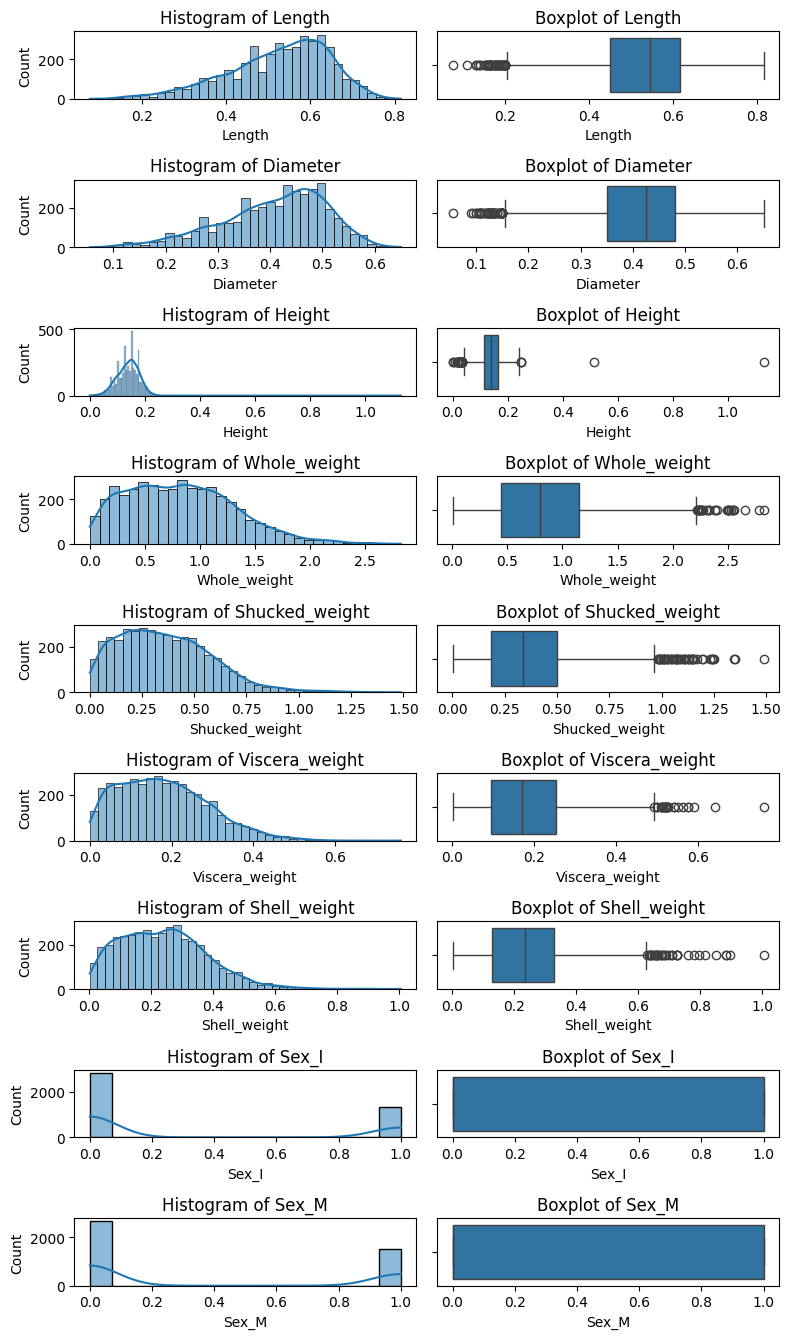

In [18]:
fig, ax = plot_feature_statistics(X, X.columns, line=False)
fig.savefig(f"{FIGS_DIR}/{eda.name}_feature-statistics.png")

So, there are some outliers. If our model is sensitive to outliers, we may need to address this.

In [19]:
# update EDA params to include information about skewness, stats, etc.
eda.update_param("skewness", "lots of skweness in the data")
eda.update_param("stats", "strangeness")
eda.update_param("outliers", "many outliers")

So, now we should check out target class distribution/stats.

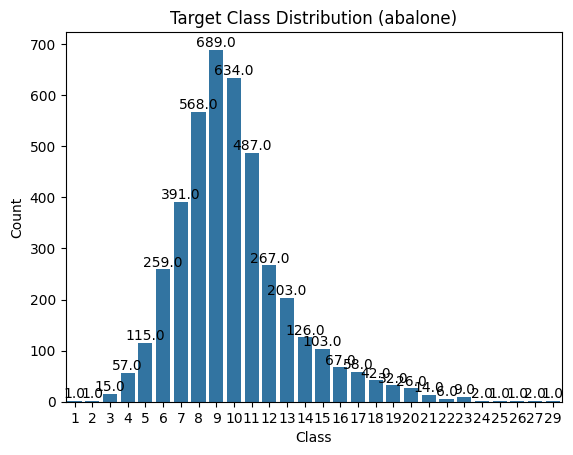

In [20]:
# class distribution of whole dataset
ax = sns.countplot(x=y.iloc[:, 0])
plt.title(f"Target Class Distribution ({eda.name})")
plt.xlabel("Class")
plt.ylabel("Count")

# Annotate each bar with the count
for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f"{height}",
        (p.get_x() + p.get_width() / 2.0, height),
        ha="center",
        va="center",
        xytext=(0, 5),
        textcoords="offset points",
    )

plt.savefig(f"{FIGS_DIR}/{eda.name}_target-class-distribution.png")
plt.show()

In [21]:
eda.update_param("class balance", "Normal with slight right skew")

## Feature Correlations

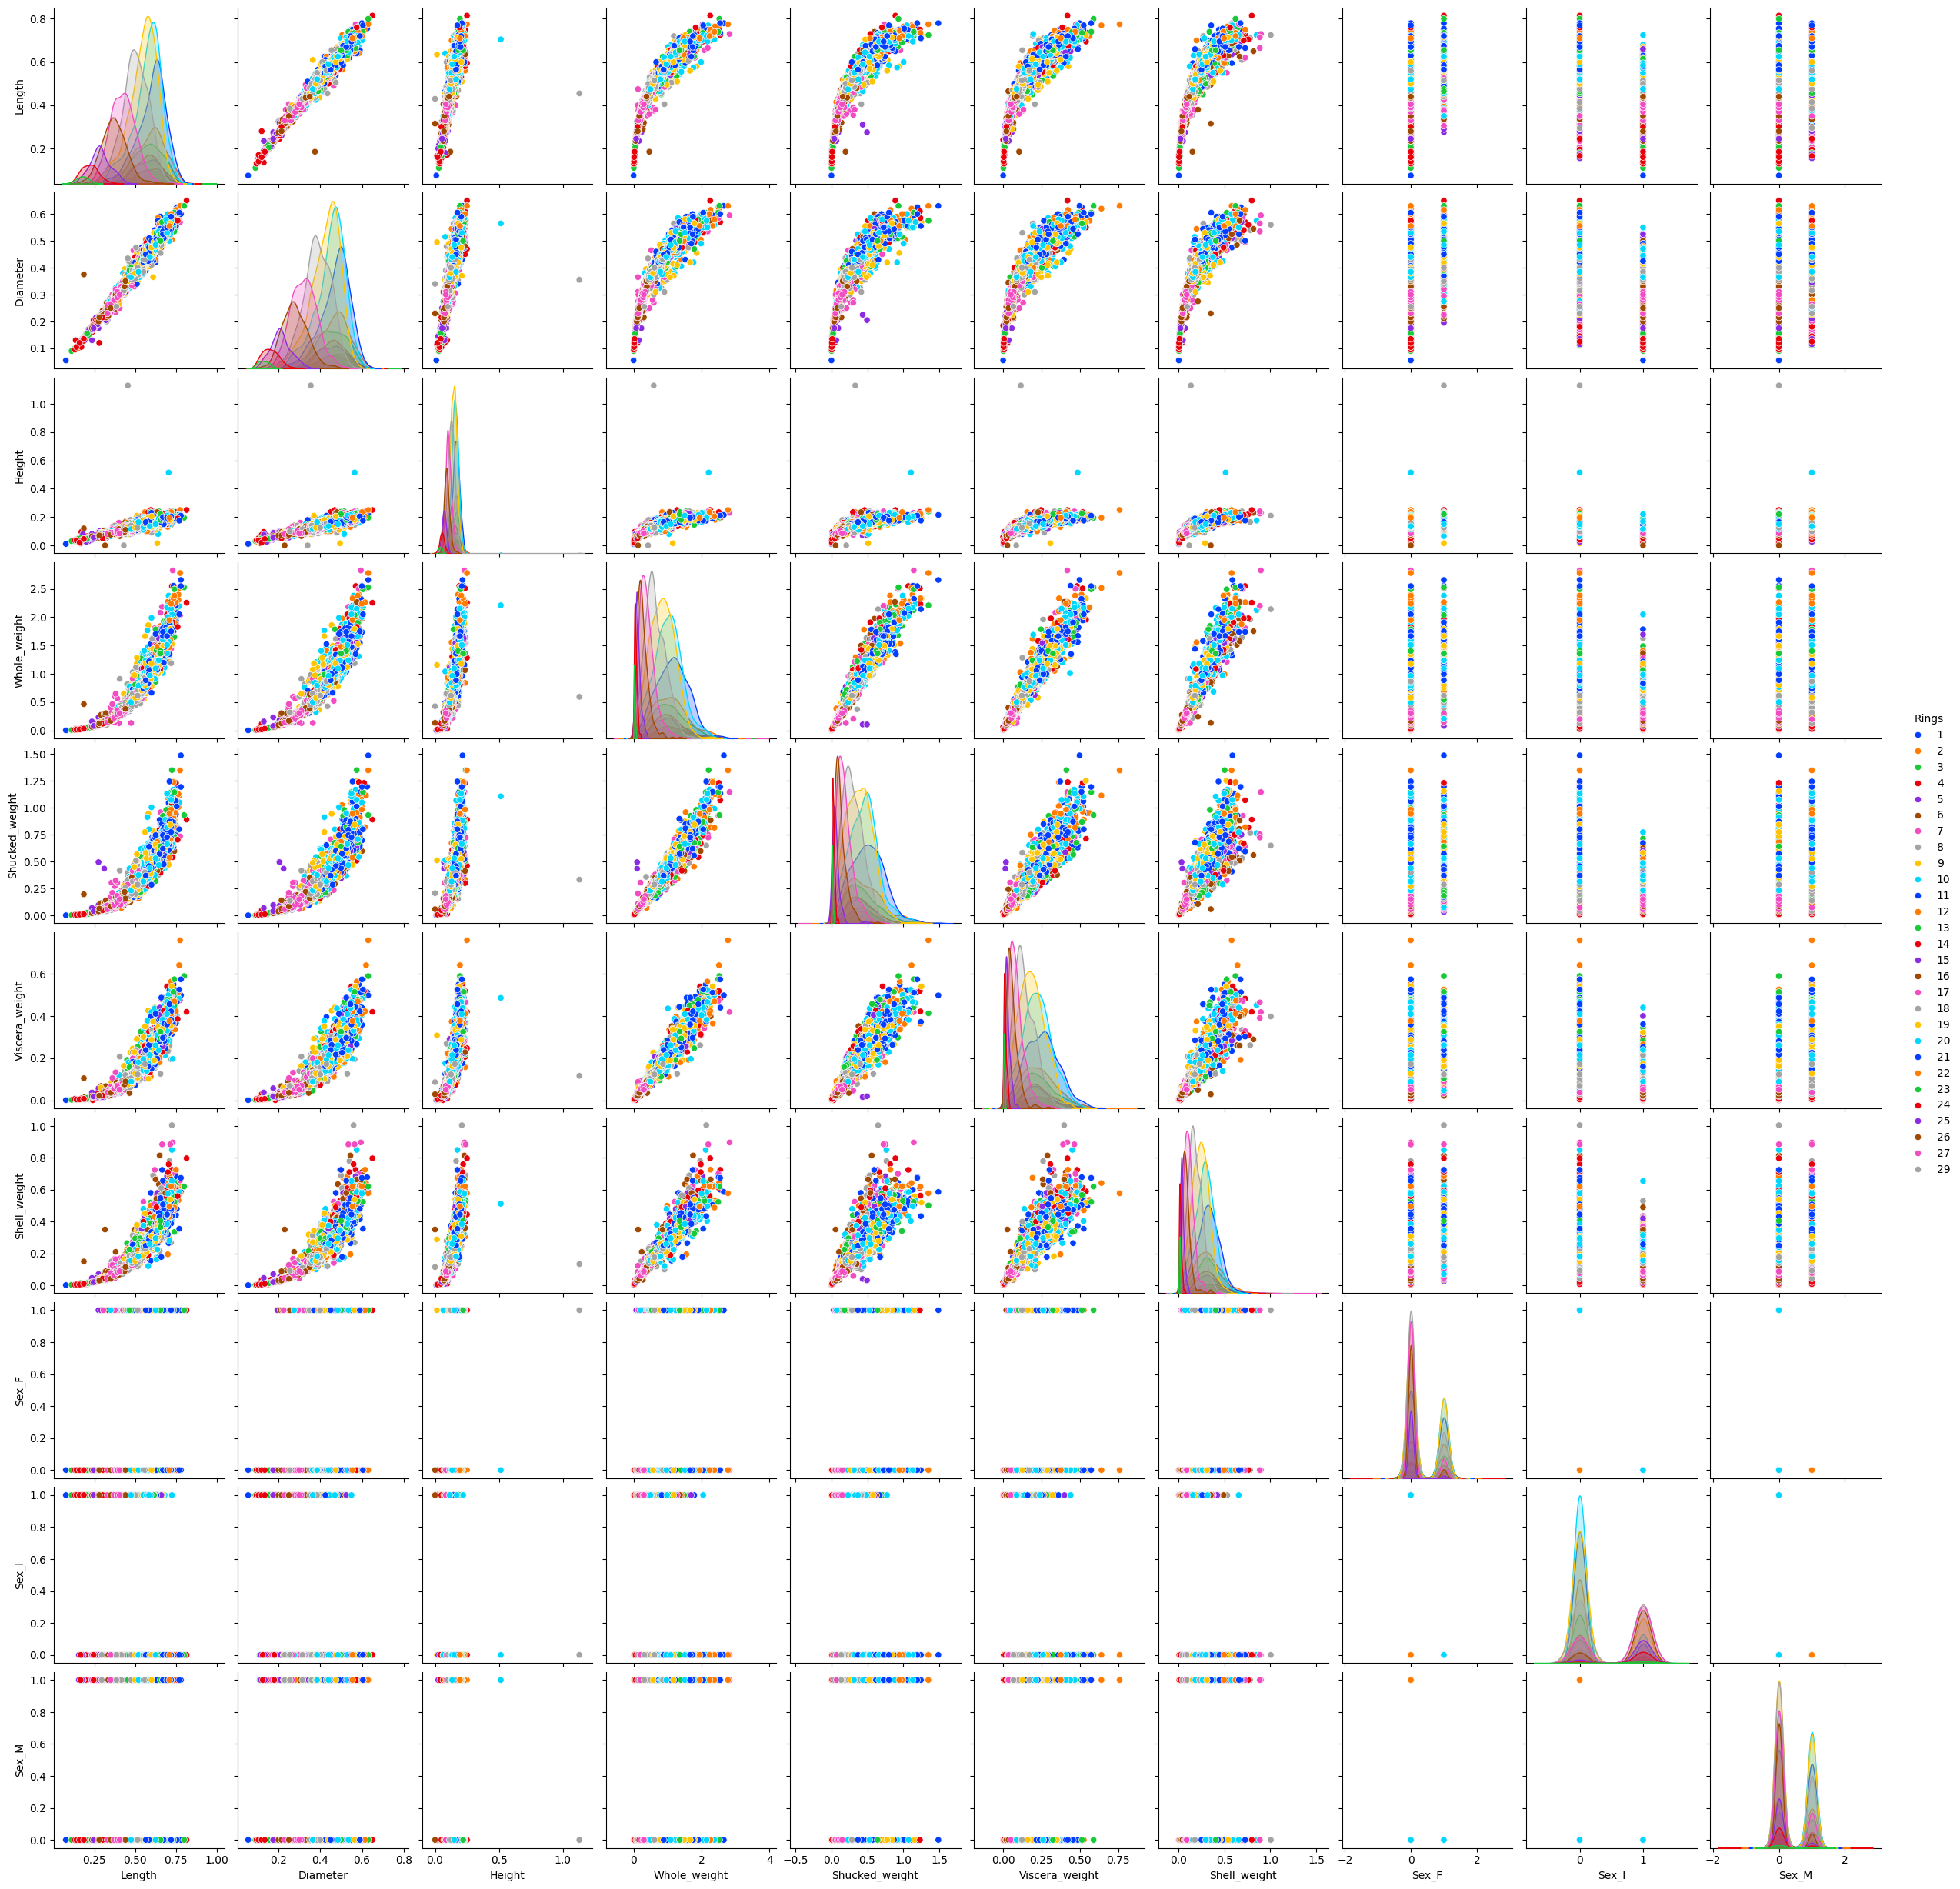

In [22]:
sns.pairplot(data=df, hue="Rings", palette="bright")
plt.savefig(f"{FIGS_DIR}/{eda.name}_pairplot.png")

Several features are highly correlated. This means there may be some redundancy in the data and thus opportunities for dimensionality reduction.

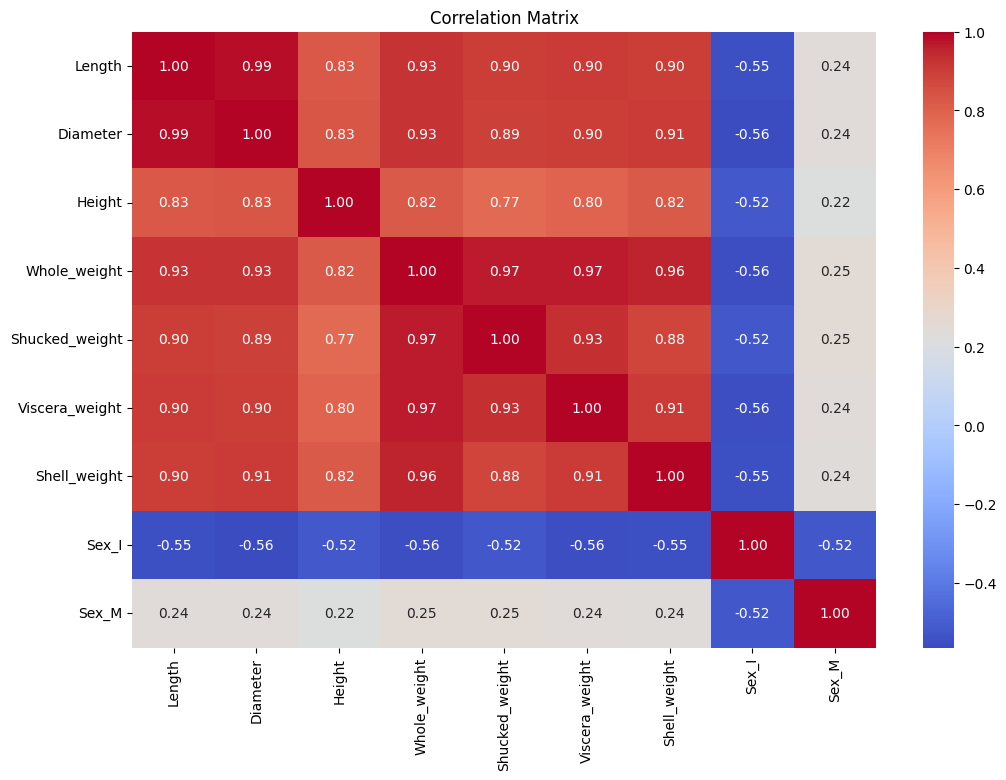

In [23]:
# Create a heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(X.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.savefig(f"{FIGS_DIR}/{eda.name}_correlation-matrix.png")
plt.show()

So there are several strong correlations between features. Update our EDA param to reflect this.

In [24]:
eda.update_param("correlations", "several strong (>.8) correlations")

## Dimensionality Reduction Potential

PCA analyzes the variance captured by each "principal component".


It identifies axes in the feature space that maximize the spread (variance) of the data.
- The first principal component (PC1) captures the most variance.
- The second principal component (PC2) captures the most variance remaining, orthogonal to PC1.
- This process continues for subsequent components.

In [25]:
# PCA - number of components to explain 95% variance
pca_pipe = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("pca", PCA()),
    ]
)
pca_pipe.fit(X)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA())])

Note: I use standard scaler here to normalize the data first because PCA is sensitive to that.

- StandardScaler: Computes the mean and standard deviation of the training data. Subtracts the mean and divides by the standard deviation for each feature, resulting in standardized data with a mean of 0 and a standard deviation of 1.

- MinMaxScaler: Computes the minimum and maximum values of the training data. Scales the data to a specified range (default is 0 to 1) based on the minimum and maximum values.

In [26]:
# here is what standard scaler did to normalize the data
X_normalized = pca_pipe.named_steps["scaler"].transform(X)
X_normalized = pd.DataFrame(X_normalized, columns=X.columns)
normd_summary_stats = X_normalized.describe().T[["min", "max", "mean", "std"]]
normd_summary_stats
# fig, ax = plot_feature_statistics(X_normalized, X.columns, line=False)
# # fig.savefig(f"{FIGS_DIR}/{eda.name}_normalized-feature-statistics.png")

,min,max,mean,std
Length,-3.739154,2.423480,-5.834718e-16,1.00012
Diameter,-3.556267,2.440025,-3.027929e-16,1.00012
Height,-3.335953,23.683287,3.912493e-16,1.00012
Whole_weight,-1.686092,4.072271,9.185853e-17,1.00012
Shucked_weight,-1.614731,5.085388,-1.020650e-17,1.00012
Viscera_weight,-1.643173,5.286500,2.704723e-16,1.00012
Shell_weight,-1.705134,5.504642,2.976897e-16,1.00012
Sex_I,-0.688018,1.453451,-7.144552e-17,1.00012
Sex_M,-0.759488,1.316677,1.169495e-17,1.00012


Good, so mean and std are 0 and 1 respectively.

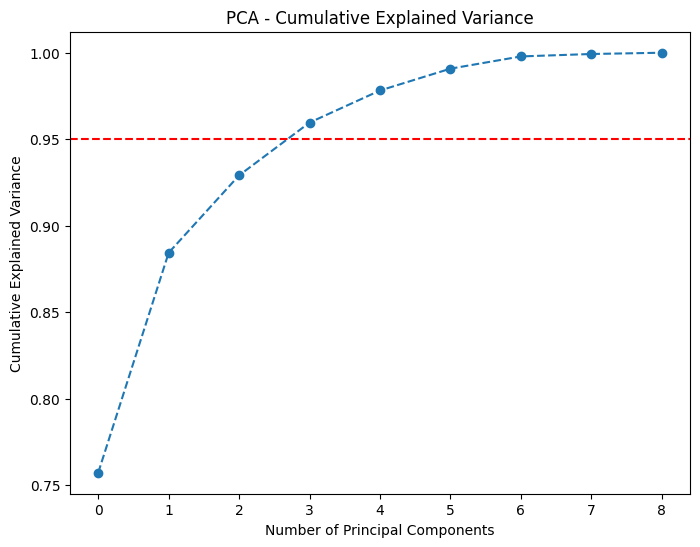

Number of components to explain 95% of the variance: 3


In [28]:
explained_variance_ratio = pca_pipe.named_steps["pca"].explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(8, 6))
plt.plot(cumulative_explained_variance, marker="o", linestyle="--")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("PCA - Cumulative Explained Variance")
plt.axhline(y=0.95, color="r", linestyle="--")  # Threshold for 95% explained variance
plt.show()

# Number of components to explain 95% variance
num_components_95 = np.argmax(cumulative_explained_variance >= 0.95)
print(f"Number of components to explain 95% of the variance: {num_components_95}")

Since 3 principal components explain 95% of the variance, it suggests that we can reduce the dimensionality to ~4 components with a good model while retaining most of the information.

We can also look at independent components analysis (ICA) to see if any components are particularly information rich.

In [29]:
# ICA - number of independent components
ica_pipe = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("ica", FastICA()),
    ]
)
components = ica_pipe.fit_transform(X)

# Number of independent components
num_independent_components = components.shape[1]
print(f"Number of independent components found: {num_independent_components}")

Number of independent components found: 9


**Q: My result confuses me...if PCA just showed that ~1/2 of our components are redundant, then why would an ICA result show that all 9 features are independent?**

*A: PCA Shows Redundancy in Variance: it suggests that ~4 of your 9 components capture most of the dataset’s variance (~95%). It doesn’t mean the other components are “useless,” just that they contribute little additional variance. ICA Shows Statistical Independence: it focuses on separating components that are statistically independent, not necessarily on variance. Even components with low variance can be statistically independent, which is why ICA might find all 9 features independent.*

In [30]:
eda.update_param(
    "DR potential",
    "PCA: 4 components to explain 95% variance, ICA: 9 statistically independent components",
)

## Save EDA results

In [31]:
eda.summary_df

,description,n features,n samples,f/n ratio,noise,stats,class balance,outliers,skewness,correlations,DR potential
dataset,,,,,,,,,,,
abalone,Predict the age (ie rings) of abalone from phy...,9,4177,0.002155,"None, no missing vals",strangeness,Normal with slight right skew,many outliers,lots of skweness in the data,several strong (>.8) correlations,"PCA: 4 components to explain 95% variance, ICA..."


In [32]:
eda.save(overwrite_existing=True)

Loading 'edas.csv'
Overwriting existing abalone
Saving abalone to results/edas.csv


---

# Create and save a shuffled 80/20 train/test split

Skipping this step for now since I don't have any intention of using this data for a model atm.